<a href="https://colab.research.google.com/github/noorulghousiah/Multi-Species-Plant-Identification/blob/main/Plant_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ghousiah_plantclef_path = kagglehub.dataset_download('ghousiah/plantclef')
ghousiah_trainedmodel_path = kagglehub.dataset_download('ghousiah/trainedmodel')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plantclef/PlantCLEF2024singleplanttrainingdata.csv
/kaggle/input/trainedmodel/ckpt.pth
/kaggle/input/trainedmodel/best_model.pt


# **DATASET**

In [ ]:
# Cell 1: Imports & Dataset Definitions
import os, time, torch, timm, numpy as np, matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn, torch.optim as optim
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

class PlantClefDataset(Dataset):
    def __init__(self, df, label_to_idx, transform=None, mode='train'):
        self.df = df[df['learn_tag']==mode].dropna(subset=['image_backup_url','species']).reset_index(drop=True)
        self.transform, self.mode = transform, mode
        self.label_to_idx = label_to_idx
        self.idx_to_label = {i: l for l, i in self.label_to_idx.items()}
        self.df['label'] = self.df['family'].map(self.label_to_idx)

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        url, lbl = self.df.loc[i, 'image_backup_url'], self.df.loc[i, 'label']
        try:
            img = Image.open(BytesIO(requests.get(url, timeout=5).content)).convert('RGB')
        except:
            img = Image.new('RGB', (224, 224), (255, 255, 255))
        if self.transform: img = self.transform(img)
        return img, lbl



class QuadratDataset(Dataset):
    def __init__(self, base_dataset, quad_size=4, transform=None):
        self.base, self.quad_size = base_dataset, quad_size
        self.transform = transform
        self.num_classes = len(self.base.label_to_idx)

    def __len__(self): return len(self.base) // self.quad_size

    def __getitem__(self, idx):
        imgs, labels = [], []
        for _ in range(self.quad_size):
            img, lbl = self.base[np.random.randint(len(self.base))]
            imgs.append(transforms.ToPILImage()(img))
            labels.append(lbl)
        w,h = imgs[0].size
        quad = Image.new('RGB', (w*2, h*2))
        coords = [(0,0),(w,0),(0,h),(w,h)]
        for im,xy in zip(imgs,coords): quad.paste(im,xy)
        if self.transform: quad = self.transform(quad)
        ml = torch.zeros(self.num_classes)
        for l in labels: ml[l] = 1
        return quad, ml


In [ ]:
import pandas as pd

# Load CSV
csv_path = '/kaggle/input/plantclef/PlantCLEF2024singleplanttrainingdata.csv'
df = pd.read_csv(csv_path, sep=';', low_memory=False)

# Drop rows without a valid 'family'
df = df.dropna(subset=['family']).reset_index(drop=True)

# Count frequency of each family
family_counts = df['family'].value_counts()

# Select top 5 most common families
top_families = family_counts.head(5).index.tolist()

# Filter dataset to only include those families
df = df[df['family'].isin(top_families)].reset_index(drop=True)

# Limit to 200 samples per class
df = df.groupby('family').head(200).reset_index(drop=True)

# Create new label mappings based on the 5 families
label_to_idx = {fam: i for i, fam in enumerate(sorted(df['family'].unique()))}
idx_to_label = {i: fam for fam, i in label_to_idx.items()}
NUM_CLASSES = len(label_to_idx)

# Map family to integer label
df['label'] = df['family'].map(label_to_idx).astype(int)

# Sanity check
print(f"Total samples after filtering: {len(df)}")
print(f"Number of classes: {NUM_CLASSES}")
print("Classes:", label_to_idx)


Total samples after filtering: 1000
Number of classes: 5
Classes: {'Asteraceae': 0, 'Brassicaceae': 1, 'Fabaceae': 2, 'Poaceae': 3, 'Rosaceae': 4}


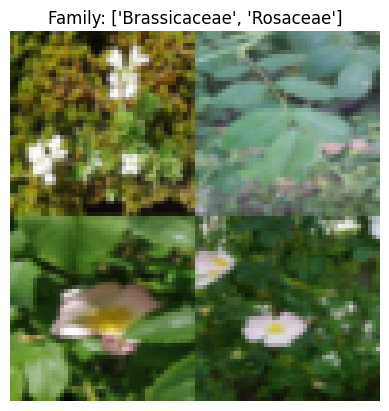

In [ ]:
from torchvision import transforms

# No normalization here, only resizing and converting to tensor
transform = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),  # Scales to [0, 1]
])

# plant_train is a PlantClefDataset
plant_train = PlantClefDataset(df, label_to_idx=label_to_idx, transform=transform, mode='train')
plant_test  = PlantClefDataset(df, label_to_idx=label_to_idx, transform=transform, mode='val')
quad_test   = QuadratDataset(plant_test, quad_size=4, transform=transform)

import matplotlib.pyplot as plt

# Pick a random index
idx = np.random.randint(len(quad_test))

# Get quadrat image and label
img, label = quad_test[idx]

# Convert tensor to NumPy and rescale for proper visualization
np_img = img.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
np_img = (np_img * 255).astype(np.uint8)  # Convert to uint8 for matplotlib

# Get label indices
label_indices = torch.nonzero(label).squeeze().tolist()
if isinstance(label_indices, int): label_indices = [label_indices]
species = [quad_test.base.idx_to_label[i] for i in label_indices]

# Show the image
plt.imshow(np_img)
plt.title(f"Family: {species}")
plt.axis('off')
plt.show()


In [ ]:


transform = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

#plant_train = PlantClefDataset(df, transform=transform, mode='train')
#plant_test  = PlantClefDataset(df, transform=transform, mode='test')

plant_train = PlantClefDataset(df, label_to_idx=label_to_idx, transform=transform, mode='train')
plant_test  = PlantClefDataset(df, label_to_idx=label_to_idx, transform=transform, mode='val')
quad_test   = QuadratDataset(plant_test, quad_size=4, transform=transform)


batch_size = 16
train_loader = DataLoader(plant_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(plant_test, batch_size=batch_size, shuffle=False, num_workers=2)
#val_loader   = DataLoader(quad_test, batch_size=batch_size, shuffle=False, num_workers=2)

#num_classes = len(plant_train.label_to_idx)
num_classes = NUM_CLASSES
print(f'Classes: {num_classes}')
print(f"Total samples in train: {len(plant_train)}")
print(f"Total samples in test: {len(plant_test)}")
print(f"Total samples in quadrat: {len(quad_test)}")


Classes: 5
Total samples in train: 966
Total samples in test: 21
Total samples in quadrat: 5


🔹 Displaying one batch from train_loader:


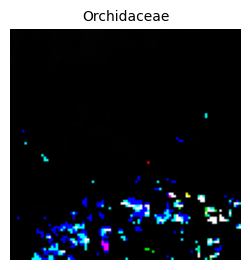

🔹 Displaying one batch from val_loader (multi-label quadrat images):


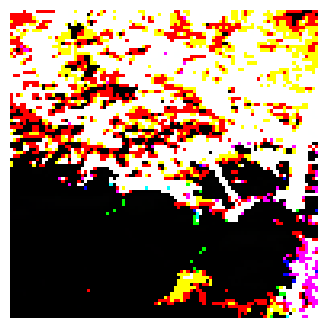

In [ ]:
import matplotlib.pyplot as plt


# --- Helper to decode single-label (train_loader) ---
def decode_single_label(label_idx, idx_to_label):
    return idx_to_label[label_idx.item()]

# --- Helper to decode multi-label (val_loader) ---
def decode_multi_labels(label_tensor, idx_to_label):
    idxs = torch.where(label_tensor == 1)[0].tolist()
    return [idx_to_label[i] for i in idxs]

# --- Display train_loader batch ---
print("🔹 Displaying one batch from train_loader:")
images, labels = next(iter(train_loader))
for i in range(min(1, len(images))):  # Show first 8
    img = images[i].permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    label_text = decode_single_label(labels[i], plant_train.idx_to_label)
    plt.title(label_text, fontsize=10)
    plt.show()

# --- Display val_loader batch (QuadratDataset) ---
print("🔹 Displaying one batch from val_loader (multi-label quadrat images):")
images, labels = next(iter(val_loader))
for i in range(min(1, len(images))):  # Show first 4 quadrat images
    img = images[i].permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    label_texts = decode_multi_labels(labels[i], plant_test.idx_to_label)
    plt.title('\n'.join(label_texts), fontsize=8)
    plt.show()


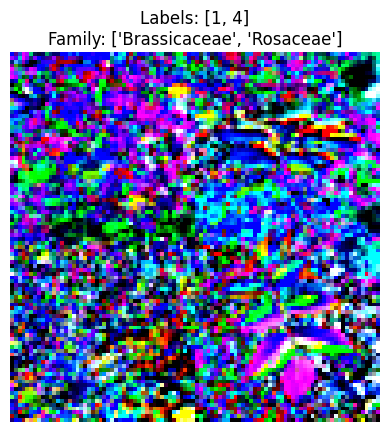

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assume `quadrat_dataset` is already created
# e.g. quadrat_dataset = QuadratDataset(train_dataset, quad_size=4, transform=...)


# Pick a random sample index
sample_idx = np.random.randint(len(quad_test))

# Get image and multi-hot label
img, label = quad_test[sample_idx]

# Convert tensor image to NumPy for displaying
np_img = img.permute(1, 2, 0).numpy()

# Get label indices (classes where label == 1)
label_indices = torch.nonzero(label).squeeze().tolist()
if isinstance(label_indices, int):
    label_indices = [label_indices]

# Map to species names
family_names = [quad_test.base.idx_to_label[i] for i in label_indices]

# Show image
plt.imshow(np_img)
plt.title(f"Labels: {label_indices}\nFamily: {family_names}")
plt.axis('off')
plt.show()



In [ ]:
print("Number of unique species (classes):", len(plant_train.label_to_idx))
print("Shape of one-hot label vector (from QuadratDataset):", quad_test [0][1].shape)


for batch in val_loader:
    imgs, labels = batch
    print("Image batch shape:", imgs.shape)   # Expected: [8, 3, 224, 224]
    print("Label batch shape:", labels.shape) # Expected: [8, 39]
    break


Number of unique species (classes): 5
Shape of one-hot label vector (from QuadratDataset): torch.Size([5])
Image batch shape: torch.Size([16, 3, 96, 96])
Label batch shape: torch.Size([16])


In [ ]:
for i in range(5):
    _, label_vec = quad_test[i]
    print(f"Sample {i} labels (indices with 1s):", torch.nonzero(label_vec).flatten().tolist())

Sample 0 labels (indices with 1s): [1, 4]
Sample 1 labels (indices with 1s): [1, 4]
Sample 2 labels (indices with 1s): [0, 1, 4]
Sample 3 labels (indices with 1s): [1, 4]
Sample 4 labels (indices with 1s): [0, 1, 4]


# **PRETRAINED MODEL**

In [ ]:
import torch, timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import numpy as np

In [ ]:
NUM_CLASSES = len(label_to_idx)  # your label count

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=NUM_CLASSES)
for p in model.parameters():
    p.requires_grad = False
for p in model.get_classifier().parameters():
    p.requires_grad = True

model = model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)



In [ ]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

In [ ]:
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 96, 96),  # match model expected input size
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                   [1, 3, 96, 96]       [1, 5]               --                   Partial
├─Conv2d (conv_stem)                          [1, 3, 96, 96]       [1, 32, 48, 48]      (864)                False
├─BatchNormAct2d (bn1)                        [1, 32, 48, 48]      [1, 32, 48, 48]      64                   False
│    └─Identity (drop)                        [1, 32, 48, 48]      [1, 32, 48, 48]      --                   --
│    └─ReLU6 (act)                            [1, 32, 48, 48]      [1, 32, 48, 48]      --                   --
├─Sequential (blocks)                         [1, 32, 48, 48]      [1, 320, 3, 3]       --                   False
│    └─Sequential (0)                         [1, 32, 48, 48]      [1, 16, 48, 48]      --                   False
│    │    └─DepthwiseSeparableConv (0)        [1, 32, 48, 48]      [1, 16, 48, 4

# **TRAINING**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import copy

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=10, save_path='best_model.pth'):
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            # Convert integer labels to one-hot vectors
            one_hot = torch.zeros(labels.size(0), NUM_CLASSES).to(device)
            one_hot[torch.arange(labels.size(0)), labels] = 1
            labels = one_hot

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate
        val_loss, val_f1 = evaluate_model(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print("✅ Best model saved.")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot loss history
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            one_hot = torch.zeros(labels.size(0), NUM_CLASSES).to(device)
            one_hot[torch.arange(labels.size(0)), labels] = 1
            labels = one_hot
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.append(preds)
            all_trues.append(labels.cpu().numpy())

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_trues)
    f1 = f1_score(y_true, y_pred, average='samples')
    return total_loss / len(val_loader), f1


Epoch 1/10 | Train Loss: 1.4957 | Val Loss: 2.4124 | Val F1: 0.2206
✅ Best model saved.
Epoch 2/10 | Train Loss: 1.3158 | Val Loss: 2.2920 | Val F1: 0.1667
Epoch 3/10 | Train Loss: 1.2646 | Val Loss: 2.1306 | Val F1: 0.1032
Epoch 4/10 | Train Loss: 1.1669 | Val Loss: 2.0475 | Val F1: 0.1111
Epoch 5/10 | Train Loss: 1.1182 | Val Loss: 2.0380 | Val F1: 0.1111
Epoch 6/10 | Train Loss: 1.1173 | Val Loss: 1.8674 | Val F1: 0.0952
Epoch 7/10 | Train Loss: 1.1151 | Val Loss: 2.1659 | Val F1: 0.1143
Epoch 8/10 | Train Loss: 1.0666 | Val Loss: 2.0420 | Val F1: 0.0952
Epoch 9/10 | Train Loss: 1.0583 | Val Loss: 1.6798 | Val F1: 0.1429
Epoch 10/10 | Train Loss: 1.0360 | Val Loss: 1.8133 | Val F1: 0.1032


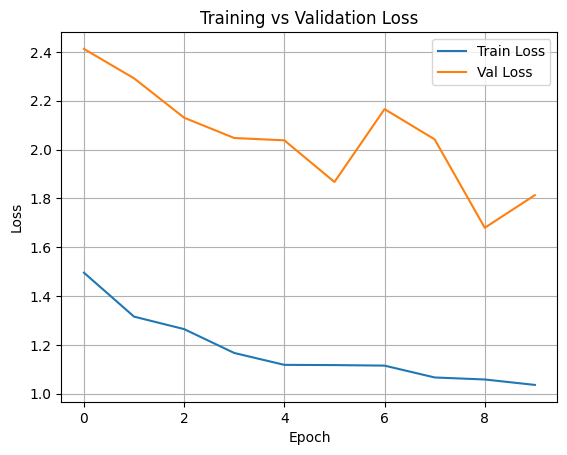

In [ ]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=10)

In [ ]:
torch.save(model.state_dict(), 'final_model.pth')
print("💾 Final model saved as 'final_model.pth'.")


💾 Final model saved as 'final_model.pth'.


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 10,
    # add any other training info here
}, 'final_checkpoint.pth')


# **EVALUATION**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_quadrats(model, quad_loader, idx_to_label, threshold=0.5):
    model.eval()
    all_preds = []
    all_trues = []
    pred_names = []

    with torch.no_grad():
        for images, labels in quad_loader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > threshold).astype(int)

            all_preds.append(preds)
            all_trues.append(labels.numpy())

            # Convert predictions to class name lists
            for sample_pred in preds:
                class_indices = np.where(sample_pred == 1)[0]
                class_names = [idx_to_label[i] for i in class_indices]
                pred_names.append(class_names)

    # Metrics
    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_trues)

    f1 = f1_score(y_true, y_pred, average='samples')
    precision = precision_score(y_true, y_pred, average='samples')
    recall = recall_score(y_true, y_pred, average='samples')

    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return pred_names, y_pred, y_true


In [ ]:
quad_loader = DataLoader(quad_test, batch_size=5, shuffle=False, num_workers=2)
pred_class_names, pred_bin, true_bin = evaluate_quadrats(model, quad_loader, idx_to_label)
print("Sample prediction (class names):", pred_class_names[0])


F1 Score: 0.0800
Precision: 0.0667
Recall: 0.1000
Sample prediction (class names): ['Fabaceae', 'Poaceae']


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# import numpy as np
# # Cell 4: Training + Validation Loop with Saving
# best_loss = float('inf')
# history = []

# for epoch in range(start_epoch,20):
#     model.train()
#     running_loss = 0
#     for x,y_lbl in train_loader:
#         x, y_lbl = x.to(device), nn.functional.one_hot(y_lbl, num_classes).float().to(device)
#         optimizer.zero_grad()
#         out = model(x)
#         loss = loss_fn(out, y_lbl)
#         loss.backward(); optimizer.step()
#         running_loss += loss.item()*x.size(0)
#     train_loss = running_loss / len(train_loader.dataset)

#     model.eval()
#     val_loss, y_true, y_pred = 0, [], []
#     with torch.no_grad():
#         for x,y_lbl in val_loader:
#             x = x.to(device)
#             ml = y_lbl.to(device)
#             out = model(x)
#             loss = loss_fn(out, ml)
#             val_loss += loss.item()*x.size(0)
#             y_true.extend(ml.cpu().numpy())
#             y_pred.extend((torch.sigmoid(out)>0.5).cpu().numpy())
#     val_loss /= len(val_loader.dataset)
#     history.append((train_loss, val_loss))
#     np.save('/kaggle/working/history.npy', np.array(history))

#     print(f"Epoch {epoch}/{20} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#     if val_loss < best_loss:
#         best_loss = val_loss
#         torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
#         save_ckpt(model, optimizer, epoch)
#         print("👉 Saved best model & checkpoint")


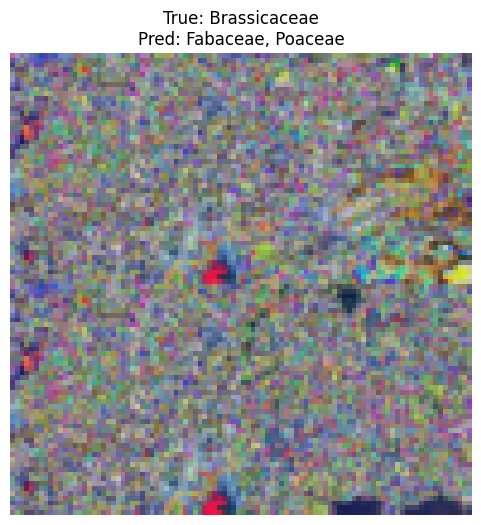

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def visualize_quadrat_sample(dataset, model, idx_to_label, threshold=0.5):
    model.eval()
    image, true_labels = dataset[0]  # One sample
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_labels = (torch.sigmoid(output) > threshold).squeeze().cpu().numpy()

    # Convert image grid back to display
    grid_img = make_grid(image, nrow=2).permute(1, 2, 0)
    grid_img = grid_img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    grid_img = grid_img.clamp(0, 1).numpy()

    # Decode labels
    true_names = [idx_to_label[i] for i in np.where(true_labels == 1)[0]]
    pred_names = [idx_to_label[i] for i in np.where(pred_labels == 1)[0]]

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(grid_img)
    plt.title(f"True: {', '.join(true_names)}\nPred: {', '.join(pred_names)}")
    plt.axis('off')
    plt.show()

visualize_quadrat_sample(quad_test, model, idx_to_label)

In [ ]:
def evaluate_quadrats(model, quad_loader, idx_to_label, threshold=0.5):
    model.eval()
    pred_bin_all = []
    true_bin_all = []
    pred_class_names_all = []
    true_class_names_all = []

    with torch.no_grad():
        for images, labels in quad_loader:
            images = images.to(model.device if hasattr(model, "device") else "cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds_bin = (probs > threshold).astype(int)

            pred_bin_all.extend(preds_bin)
            true_bin_all.extend(labels.numpy())

            # Convert predictions to class names
            for pred_vec in preds_bin:
                pred_classes = [idx_to_label[i] for i in range(len(pred_vec)) if pred_vec[i] == 1]
                pred_class_names_all.append(pred_classes)

            # Convert true labels to class names
            for true_vec in labels.numpy():
                true_classes = [idx_to_label[i] for i in range(len(true_vec)) if true_vec[i] == 1]
                true_class_names_all.append(true_classes)

    return pred_class_names_all, pred_bin_all, true_bin_all, true_class_names_all


In [ ]:
pred_class_names, pred_bin, true_bin, true_class_names = evaluate_quadrats(model, quad_loader, idx_to_label)

# Print one example
# print("✅ Sample prediction (class names):", pred_class_names[0])
# print("🎯 Ground truth (class names):", true_class_names[0])

for i in range(len(pred_class_names)):
    print(f"🟩 Sample {i+1}")
    print("✅ Predicted :", pred_class_names[i])
    print("🎯 Ground truth:", true_class_names[i])
    print("-" * 50)

🟩 Sample 1
✅ Predicted : ['Fabaceae']
🎯 Ground truth: ['Asteraceae', 'Brassicaceae', 'Rosaceae']
--------------------------------------------------
🟩 Sample 2
✅ Predicted : ['Fabaceae', 'Poaceae']
🎯 Ground truth: ['Asteraceae', 'Brassicaceae']
--------------------------------------------------
🟩 Sample 3
✅ Predicted : ['Brassicaceae', 'Fabaceae', 'Rosaceae']
🎯 Ground truth: ['Brassicaceae', 'Rosaceae']
--------------------------------------------------
🟩 Sample 4
✅ Predicted : ['Poaceae']
🎯 Ground truth: ['Brassicaceae', 'Rosaceae']
--------------------------------------------------
🟩 Sample 5
✅ Predicted : ['Fabaceae', 'Poaceae']
🎯 Ground truth: ['Brassicaceae']
--------------------------------------------------
